##  Analysis of Rental Rooms Amenities using Clustering and Association Rules
This project is implemented for educational purposes. It is submitted in fulfillment of Data Mining (491121) course requirements.
<br>The Goal: help hosts or property owners to optimize their rooms amenities based on customers ratings.

## 1. Introduction

### Problem & Motivation
In the competitive short-term rental market, room amenities significantly influence user expectations and pricing power. However, the value of these amenities is location-dependent. A feature valued in one area (e.g., "Air Conditioning" in a beach district) may be irrelevant in another (e.g., a "Workspace" in a financial district). Investors and hosts currently lack granular, location-aware insights to guide renovation and listing optimization. This project aims to solve this issue and helps hosts to optimize their rooms amenities to increase the chance they got booked.

### Methodology Summary
We propose a two-stage data mining approach:
1.  **Density-Based Spatial Clustering (DBSCAN):** We apply DBSCAN on geolocation data (Latitude/Longitude) to automatically detect distinct functional neighborhoods without relying on predefined city boundaries.
2.  **Association Rule Mining (FP-Growth):** We apply the FP-Growth algorithm within each identified cluster. This allows us to extract unique patterns—specifically, identifying which distinct amenities act as strong predictors for **"High Ratings"** within that specific geographic context.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import DBSCAN
from mlxtend.frequent_patterns import fpgrowth, association_rules
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.metrics import silhouette_score
import ast
import gc
import warnings

# Configuration for prettier plots
sns.set_theme(style="whitegrid")
%matplotlib inline

warnings.filterwarnings('ignore')

## 2. Data Loading

We utilized real data provided by <a href="https://insideairbnb.com/get-the-data/">an independent open-source data tool</a>. The selected dataset covers listings from **three different states in the US**, consolidated into a single local CSV file named `hosts_locations.csv`. This dataset provides a rich source of information, including geolocation, pricing, review scores, and amenity lists for thousands of listings.

In [2]:
df = pd.read_csv('hosts_locations.csv')
print(f"Dataset Shape: {df.shape}")
df.head(3)

Dataset Shape: (76255, 79)


,id,listing_url,scrape_id,last_scraped,source,name,description,neighborhood_overview,picture_url,host_id,...,review_scores_communication,review_scores_location,review_scores_value,license,instant_bookable,calculated_host_listings_count,calculated_host_listings_count_entire_homes,calculated_host_listings_count_private_rooms,calculated_host_listings_count_shared_rooms,reviews_per_month
0,1010872140278275585,https://www.airbnb.com/rooms/1010872140278275585,20241225160245,2024-12-25,previous scrape,Historic 2 Bedroom Luxury Home with FREE Parking,This historic lovely 2 bedroom/1 bath townhome...,NaN,https://a0.muscache.com/pictures/miso/Hosting-...,543562694,...,NaN,NaN,NaN,2022-1062,f,7,7,0,0,NaN
1,683894808217864012,https://www.airbnb.com/rooms/683894808217864012,20250926165842,2025-09-26,previous scrape,(3)Clintonville Getaway 3-bed Townhouse w/Parking,This home cannot guarantee an early check-in b...,NaN,https://a0.muscache.com/pictures/4b7e19d8-b658...,63784636,...,4.77,4.83,4.59,2023-4032,t,5,5,0,0,2.00
2,44031278,https://www.airbnb.com/rooms/44031278,20250819035519,2025-08-19,city scrape,"Green House by Downtown, Deep Ellum, & State Fair",NaN,NaN,https://a0.muscache.com/pictures/b6981a84-23ba...,249960325,...,4.97,4.54,4.85,NaN,t,9,3,6,0,9.29


---

## 3. Data Exploration

In this phase, we analyze the available data in terms of features and sample size. We perform Exploratory Data Analysis (EDA) to understand the distribution of key variables, check for outliers/missing values, and visualize the geographical spread of listings.

### 3.1 Feature Selection

In [3]:
print(f"We have a lot of of attributes in our data set around {len(df.columns)}. Listing a sample of the available attributes:")
df.columns[0:20].tolist()

We have a lot of of attributes in our data set around 79. Listing a sample of the available attributes:


['id',
 'listing_url',
 'scrape_id',
 'last_scraped',
 'source',
 'name',
 'description',
 'neighborhood_overview',
 'picture_url',
 'host_id',
 'host_url',
 'host_name',
 'host_since',
 'host_location',
 'host_about',
 'host_response_time',
 'host_response_rate',
 'host_acceptance_rate',
 'host_is_superhost',
 'host_thumbnail_url']

The original dataset contains approximately **79 attributes**. Many of these (e.g., `scrape_id`, `host_thumbnail_url`) are not relevant to our objective.
To focus our analysis, we filtered the dataset to the following key features:
* **Location:** `latitude`, `longitude`
* **Targets:** `price`, `review_scores_rating`
* **Features:** `amenities`

We created a new dataframe containing only these columns for processing.

In [4]:
df = df[['id', 'latitude', 'longitude', 'price', 'review_scores_rating', 'amenities']]
df.head(5)

,id,latitude,longitude,price,review_scores_rating,amenities
0,1010872140278275585,40.015790,-82.965200,NaN,NaN,"[""Hangers"", ""Cooking basics"", ""Private entranc..."
1,683894808217864012,40.024330,-83.006530,NaN,4.61,"[""Hot water"", ""Exterior security cameras on pr..."
2,44031278,32.793610,-96.757880,$103.00,4.81,"[""Carbon monoxide alarm"", ""Extra pillows and b..."
3,54309874,32.747680,-96.832190,$77.00,4.84,"[""Portable fans"", ""Exercise equipment"", ""Bakin..."
4,1394911289846633367,39.977385,-83.004781,$96.00,4.79,"[""Hot water"", ""Air conditioning"", ""Dishes and ..."


### 3.2 Missing Value Analysis

We identified missing values in both `review_scores_rating` and `price`. Handling these is critical to avoid bias in our model.

In [5]:
print(f"Missing Ratings: {df['review_scores_rating'].isnull().sum()} out of {len(df)}")

Missing Ratings: 10878 out of 76255


In [6]:
print(f"Missing Prices: {df['price'].isnull().sum()} out of {len(df)}")

Missing Prices: 5030 out of 76255


In [7]:
print(f"Missing longitude: {df['longitude'].isnull().sum()} out of {len(df)}")

Missing longitude: 0 out of 76255


In [8]:
print(f"Missing amenities: {df['amenities'].isnull().sum()} out of {len(df)}")

Missing amenities: 0 out of 76255


So we have some missing values in both *review_scores_rating* and *price* that we may need to handle

### 3.3 Review_Scores_Rating Attribute Distribution
The rating data is typically highly skewed, with the majority of ratings falling between 4.0 and 5.0. To perform effective Association Rule Mining, we must discretize this continuous variable into a binary target: **"High Rating"**. Analyzing the distribution helps us determine the appropriate threshold to separate top-performing listings from the rest.

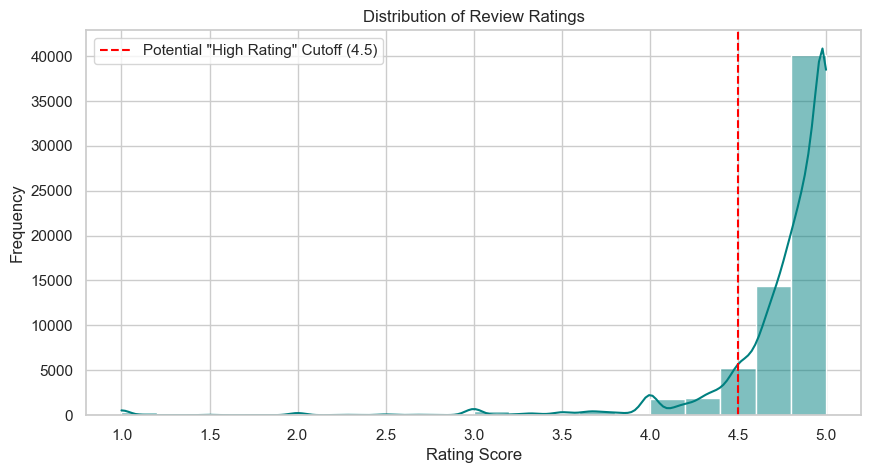

In [9]:
plt.figure(figsize=(10, 5))
sns.histplot(df['review_scores_rating'], bins=20, kde=True, color='teal')
plt.title('Distribution of Review Ratings')
plt.xlabel('Rating Score')
plt.ylabel('Frequency')
plt.axvline(x=4.5, color='red', linestyle='--', label='Potential "High Rating" Cutoff (4.5)')
plt.legend()
plt.show()

As we can see that 90% of listings have a rating > 4. This confirms we should select a high value for our High_Rating threshold may be some value around (4.5). 

### 3.4 Geospatial Density (Pre-Clustering)
Before we ask the algorithm (DBSCAN) to find clusters, let's look at the raw map to see if there are obvious "hotspots." and as we said earlier the data belong to three different states of US which will be clear in the following scatterplot

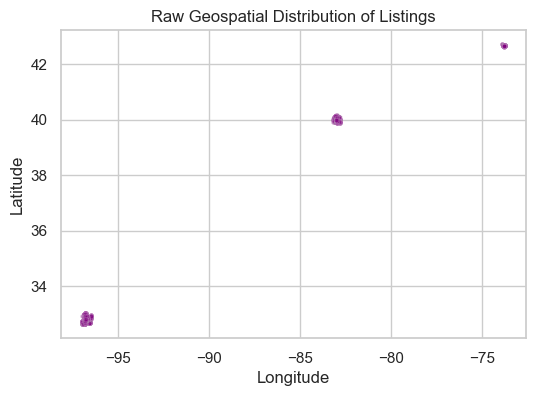

In [10]:
plt.figure(figsize=(6, 4))
sns.scatterplot(x='longitude', y='latitude', data=df, alpha=0.1, color='purple', s=10)
plt.title('Raw Geospatial Distribution of Listings')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### 3.5 Top Amenities Analysis
We need to know which amenities appear most frequently. If "Wifi" appears in 99% of listings, it won't be a useful rule (it has no discriminative power).

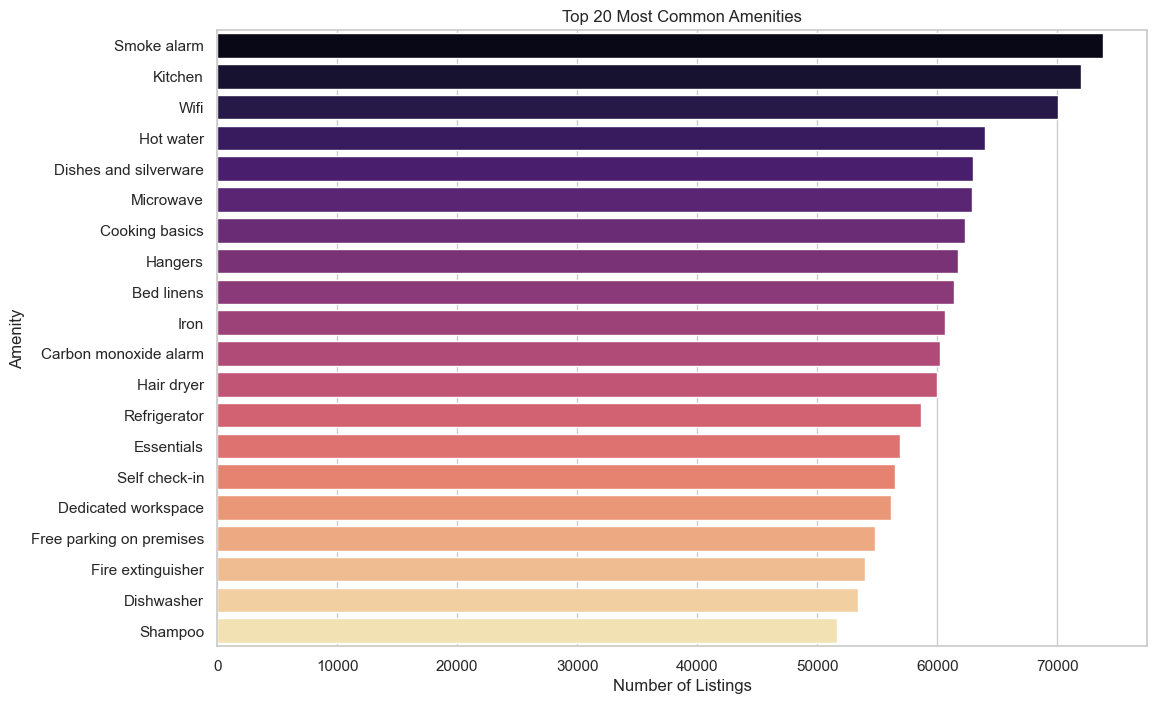

In [11]:
# Parse string representation of list to actual list
def parse_amenities(x):
    try:
        # Handling different formats of stringified lists (Airbnb format varies)
        x = x.replace('{', '[').replace('}', ']')
        return ast.literal_eval(x)
    except:
        return []

# We need to temporarily parse the amenities to count them
from collections import Counter

# Flatten the list of lists into one giant list of amenities
all_amenities = [item for sublist in df['amenities'].apply(parse_amenities) for item in sublist]
amenity_counts = Counter(all_amenities)

# Convert to DataFrame for plotting
df_amenity_counts = pd.DataFrame(amenity_counts.most_common(20), columns=['Amenity', 'Count'])

plt.figure(figsize=(12, 8))
sns.barplot(y='Amenity', x='Count', data=df_amenity_counts, palette='magma')
plt.title('Top 20 Most Common Amenities')
plt.xlabel('Number of Listings')
plt.show()

---

## 4. Data Preprocessing
In this phase we will clean our data by filling in the missing rating attribute values. Also we clean the amenities from common and outlier instances. and We need to to perform some data transformation techniques to prepare the data for both DBSCAN (Needs coordinates) and Association Rules (Needs binary data).

### 4.1 Fill missing ratings with the mean
We choose to fill review_scores_rating by using that attributes mean. 

In [12]:
df['review_scores_rating'] = df['review_scores_rating'].fillna(df['review_scores_rating'].mean())

### 3.2 Cleaning and Parsing Amenities
We need to parse amenties into items and to clean the amenties from duplicate keywords as much as pssoible (tv, telvision) or (wifi,internet) ..etc 

In [13]:
# Parse string representation of amenities list to actual list
def parse_amenities(x):
    try:
        x = x.replace('{', '[').replace('}', ']')
        return ast.literal_eval(x)
    except:
        return []

# Clean the parsed each amenities strings
def clean_amenity_list(amenity_list):
    """
    Standardizes common messy amenity strings into simple categories.
    Example: "50 inch HDTV with Netflix" -> ["TV", "Netflix"]
    """
    cleaned_list = []
    
    for item in amenity_list:
        item_str = str(item).lower()

        for word in ['yes','\n','\t']:
            if word in item_str:
                item_str = item_str.replace(word,"")
                
        # Handle TV & Streaming stuff
        if 'tv' in item_str or 'cable' in item_str:
            cleaned_list.append('TV')
            if any(x in item_str for x in ['netflix', 'hulu', 'hbo', 'disney', 'apple tv', 'amazon prime']):
                cleaned_list.append('Streaming Service')
        
        # Handle Internet
        elif 'wifi' in item_str or 'internet' in item_str:
            cleaned_list.append('Wifi')
            
        # Handle Climate
        elif 'air conditioning' in item_str or 'ac ' in item_str:
            cleaned_list.append('Air conditioning')
        elif 'heating' in item_str or 'heater' in item_str:
            cleaned_list.append('Heating')
            
        # Handle Kitchen specifics
        elif 'coffee' in item_str or 'espresso' in item_str:
            cleaned_list.append('Coffee Maker')
        elif 'refrigerator' in item_str or 'fridge' in item_str:
            cleaned_list.append('Refrigerator')
        elif 'stove' in item_str or 'oven' in item_str:
            cleaned_list.append('Stove')
            
        # Handle "Long Junk Strings"
        # If a string is > 35 chars and didn't match the keywords above, it's likely noise.
        elif len(item_str) > 35 or 'wine' in item_str:
            continue # Skip it (e.g., "paid parking off premises...")
            
        # Keep short, clean items (e.g., "Pool", "Gym", "Iron")
        else:
            # Capitalize first letter for consistency
            cleaned_list.append(item_str.title())
            
    # Remove duplicates (e.g., if "TV" was added twice from the same string)
    return list(set(cleaned_list))

# Apply Parsing
df['amenities_list'] = df['amenities'].apply(parse_amenities)

# Apply Cleaning
df['amenities_list'] = df['amenities_list'].apply(clean_amenity_list)

In [14]:
print("Sample of Amenities After Cleaning:\n", df['amenities_list'].iloc[0][:20])

Sample of Amenities After Cleaning:
 ['Stove', 'Free Parking On Premises', 'Refrigerator', 'Essentials', 'Patio Or Balcony', 'Iron', 'Dishes And Silverware', 'TV', 'Bathtub', 'Kitchen', 'Air conditioning', 'Body Soap', 'Heating', 'Private Entrance', 'Long Term Stays Allowed', 'Dedicated Workspace', 'Cooking Basics', 'Laundromat Nearby', 'Carbon Monoxide Alarm', 'Free Street Parking']


The amenities column usually comes as a string representation of a list (e.g., "{'TV', 'Wifi'}"). We need to one-hot encode this. and drop most common amentias that appear approximately in every transaction.

In [15]:
# One-Hot Encoding for the cleaned amenities
mlb = MultiLabelBinarizer()
amenities_ohe = mlb.fit_transform(df['amenities_list'])
df_amenities = pd.DataFrame(amenities_ohe, columns=mlb.classes_, index=df.index)
df_amenities.head(5)

,Body Soap,Conditioner,Dove Body Soap,Shampoo,(Generic) Conditioner,(Generic) Shampoo,100% Vegan & Cruelty-Free Body Soap,100% Vegan & Cruelty-Free Shampoo,100% Vegan Body Soap,100% Vegan Conditioner,...,Yamaha Sound System With Aux,Yamaha Bluetooth Sound System,Yamaha Sound System With Aux,Zeroderm Fragrance Free Body Soap,Zogics Organics Body Soap,Zogics Organics Conditioner,Zogics Organics Shampoo,“Everyone” Brand Soap Body Soap,“Everyone” Soap Body Soap,“Everyone” Soap/Shampoo Shampoo
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


Feature Selection: Prune Amenities with that likely lower the 'upper_limit' because "Wifi" will be even more common now that we fixed the spelling variations

In [ ]:
# Feature Pruning
amenity_support = df_amenities.mean()
# now likely lower the 'upper_limit' because "Wifi" will be even more common now that we fixed the spelling variations
too_common = amenity_support[amenity_support > 0.9].index.tolist() 
too_rare = amenity_support[amenity_support < 0.01].index.tolist()
cols_to_drop = too_common + too_rare

df_amenities_clean = df_amenities.drop(columns=cols_to_drop)

print(f"Final Cleaned Features(Amenities) Count: {df_amenities_clean.shape[1]}")

# Combine
df_processed = pd.concat([df[['latitude', 'longitude', 'review_scores_rating', 'price']], df_amenities_clean], axis=1)
df_processed.head(5)

Final Cleaned Features(Amenities) Count: 151


,latitude,longitude,review_scores_rating,price,Arcade Games,Baby Bath,Baby Safety Gates,Babysitter Recommendations,Backyard,Baking Sheet,...,Smoking Allowed,Sound System,Stove,Streaming Service,Sun Loungers,Theme Room,Toaster,Trash Compactor,Washer,Window Guards
0,40.015790,-82.965200,4.751176,NaN,0,0,0,0,0,0,...,0,0,1,0,0,0,0,0,0,0
1,40.024330,-83.006530,4.610000,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,32.793610,-96.757880,4.810000,$103.00,0,0,0,0,1,0,...,0,0,1,0,0,0,0,0,0,0
3,32.747680,-96.832190,4.840000,$77.00,0,0,0,0,0,1,...,0,0,1,0,0,0,0,0,0,0
4,39.977385,-83.004781,4.790000,$96.00,0,0,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0


### 4.2 Discretize High_Rating attribute so it will be used in the association rules mining step 

In [17]:
# 3. Discretize Target
df_processed['High_Rating'] = (df_processed['review_scores_rating'] >= 4.5).astype(int)
df_processed.head(5)

,latitude,longitude,review_scores_rating,price,Arcade Games,Baby Bath,Baby Safety Gates,Babysitter Recommendations,Backyard,Baking Sheet,...,Sound System,Stove,Streaming Service,Sun Loungers,Theme Room,Toaster,Trash Compactor,Washer,Window Guards,High_Rating
0,40.015790,-82.965200,4.751176,NaN,0,0,0,0,0,0,...,0,1,0,0,0,0,0,0,0,1
1,40.024330,-83.006530,4.610000,NaN,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,1
2,32.793610,-96.757880,4.810000,$103.00,0,0,0,0,1,0,...,0,1,0,0,0,0,0,0,0,1
3,32.747680,-96.832190,4.840000,$77.00,0,0,0,0,0,1,...,0,1,0,0,0,0,0,0,0,1
4,39.977385,-83.004781,4.790000,$96.00,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,1


---

## 5. Clustering Phase (DBSCAN)

The goal of this phase is to segment the market based on geo-location.

We utilize **DBSCAN (Density-Based Spatial Clustering)** with the **Haversine Distance** metric.
* **Why Haversine?** Standard Euclidean distance does not account for the curvature of the earth, making it inaccurate for geospatial coordinates (Latitude/Longitude). Haversine distance correctly calculates the great-circle distance between two points.

### 5.1 DBSCAN Parameter Tuning: 
DBSCAN requires two key parameters: `eps` (radius of the neighborhood) and `min_samples` (density threshold). We performed a search to optimize these parameters using the **Silhouette Score**, which measures how similar an object is to its own cluster compared to other clusters. Finally since we use radians for eps, eps must be (# of kilometers / Mean Earth Radius (R): approximately 6,371 km.)



Tuning DBSCAN Hyperparameters ...

Best Parameters Found:
 -> Eps: 3 km
 -> Min Samples: 15
 -> Number of Clusters: 5
 -> Best Silhouette Score: 0.704


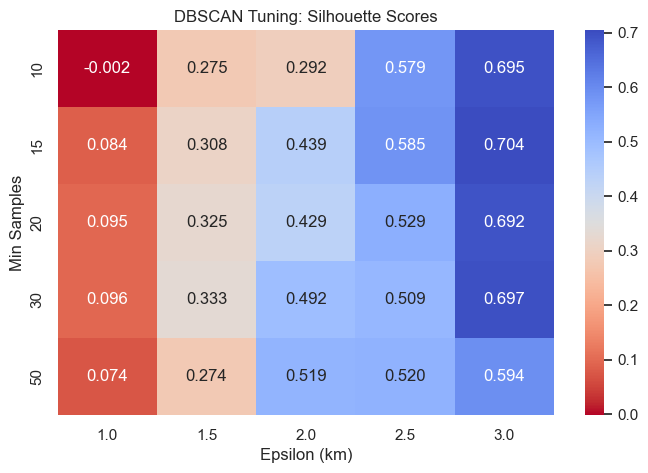

In [40]:
def tune_dbscan_hyperparameters(coords_radians):
    """
    Search to find the best DBSCAN parameters using Silhouette Score.
    """
    print("Tuning DBSCAN Hyperparameters ...")
    
    # Define Parameter Grid
    # eps in km (converted to radians inside loop)
    eps_km_options = [1, 1.5, 2, 2.5, 3] 
    # min_samples
    min_samples_options = [10, 15, 20, 30, 50]
    
    kms_per_radian = 6371.0088
    best_score = -1
    best_params = {'eps_km': None, 'min_samples': None}
    
    results = []

    for eps_km in eps_km_options:
        for min_samples in min_samples_options:
            eps_rad = eps_km / kms_per_radian
            
            # Fit DBSCAN
            db = DBSCAN(eps=eps_rad, min_samples=min_samples, metric='haversine', algorithm='ball_tree')
            labels = db.fit_predict(coords_radians)
            
            # Ignore Noise (-1) for scoring
            core_mask = labels != -1
            unique_clusters = set(labels[core_mask])
            
            # We need at least 2 distinct clusters to calculate a silhouette score
            if len(unique_clusters) < 2:
                continue
                
            # Calculate Silhouette Score
            # Note: We calculate score ONLY on the clustered points, not the noise
            score = silhouette_score(coords_radians[core_mask], labels[core_mask], metric='haversine', sample_size=7000)
            
            
            results.append({
                'eps_km': eps_km,
                'min_samples': min_samples,
                'score': score,
                'n_clusters': len(unique_clusters)
            })
            
            # Save Best (Penalty if noise is too high > 50%)
            if score > best_score:
                best_score = score
                best_params = {'eps_km': eps_km, 'min_samples': min_samples, 'n_clusters': len(unique_clusters)}

    # Convert results to DataFrame for visualization
    results_df = pd.DataFrame(results)
    
    print(f"\nBest Parameters Found:")
    print(f" -> Eps: {best_params['eps_km']} km")
    print(f" -> Min Samples: {best_params['min_samples']}")
    print(f" -> Number of Clusters: {best_params['n_clusters']}")
    print(f" -> Best Silhouette Score: {best_score:.3f}")
    
    return best_params, results_df

# EXECUTION

# Prepare Coordinates
coords = np.radians(df_processed[['latitude', 'longitude']].values)

# Run Tuning
best_params, tuning_results = tune_dbscan_hyperparameters(coords)

# Visualize the "Sweet Spot" (Heatmap)
if not tuning_results.empty:
    pivot_table = tuning_results.pivot(index="min_samples", columns="eps_km", values="score")
    plt.figure(figsize=(8, 5))
    sns.heatmap(pivot_table, annot=True, cmap="coolwarm_r", fmt=".3f")
    plt.title("DBSCAN Tuning: Silhouette Scores")
    plt.xlabel("Epsilon (km)")
    plt.ylabel("Min Samples")
    plt.show()

### 5.2 Perform CLustering using the best parameters Found

In [41]:
# Prepare Coordinates
# We use the lat/lon from our clean dataframe to ensure alignment
# .values is used to convert the Pandas DataFrame to a NumPy array for Scikit-Learn
coords = df_processed[['latitude', 'longitude']].values

# Convert to Radians (Required for Haversine metric in Sklearn)
coords_radians = np.radians(coords)

# Configure DBSCAN

# Apply Final Clustering with Best Params
kms_per_rad = 6371.0088 # Earth's radius in km approx 6371
final_eps = best_params['eps_km'] / kms_per_rad
final_min = best_params['min_samples']

print(f"Running DBSCAN with eps={final_eps:.6f} radians (approx {best_params['eps_km']} km) and min_samples of ({final_min})...")

db = DBSCAN(eps=final_eps, min_samples=final_min, metric='haversine', algorithm='ball_tree')

# Fit and Assign Clusters Labels
# We fit the model on coordinates, then assign the labels back to our main dataframe
df_processed['cluster'] = db.fit_predict(coords_radians)
print(f"completed")

# 5. Show Final Map
n_clusters = len(df_processed[df_processed['cluster'] != -1]['cluster'].unique())
print(f"\nFinal Clustering: {n_clusters} Neighborhoods Identified")

Running DBSCAN with eps=0.000471 radians (approx 3 km) and min_samples of (15)...
completed

Final Clustering: 5 Neighborhoods Identified


### 5.3 Analyzing cluster results:
We will select top 3 largest clusters and we will neglect the others as noise, since we know previously that the data related to 3 different states.


--- Clustering Results ---
Estimated number of clusters: 5
Noise points (outliers): 0
Top 5 Largest Clusters (by # of listings):
cluster
1    60715
0    11191
2     4133
4       75
3       64
Name: count, dtype: int64


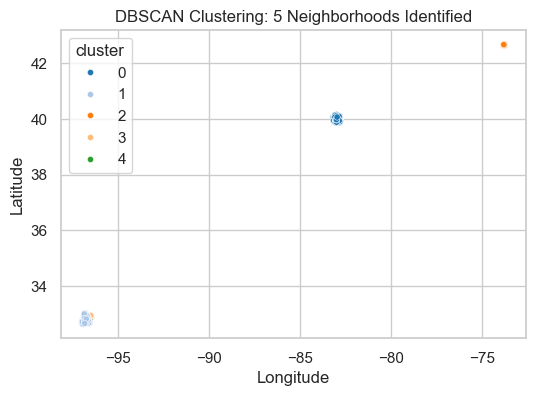

In [42]:
df_processed = df_processed[df_processed['cluster'] != -1]
cluster_counts = df_processed['cluster'].value_counts()
n_clusters = len(cluster_counts[cluster_counts.index != -1])
n_noise = cluster_counts.get(-1, 0)

print(f"\n--- Clustering Results ---")
print(f"Estimated number of clusters: {n_clusters}")
print(f"Noise points (outliers): {n_noise}")
print(f"Top 5 Largest Clusters (by # of listings):")
print(cluster_counts.head(5))

# Visualization (Sanity Check)
plt.figure(figsize=(6, 4))
sns.scatterplot(
    data=df_processed, 
    x='longitude', 
    y='latitude', 
    hue='cluster', 
    palette='tab20', # A palette with many distinct colors
    s=20, 
)
plt.title(f'DBSCAN Clustering: {n_clusters} Neighborhoods Identified')
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.show()

### Visualize each cluster of the selected clusters

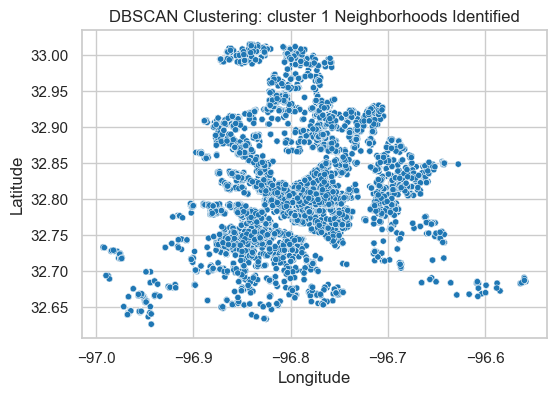

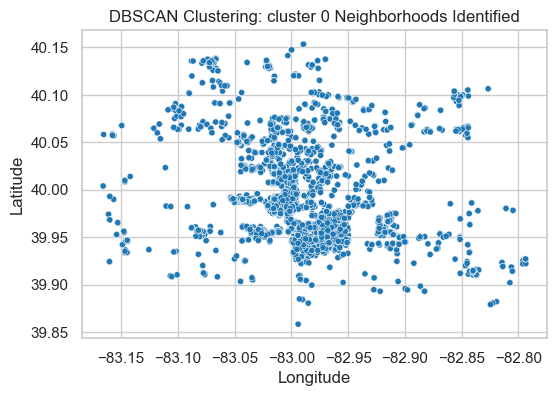

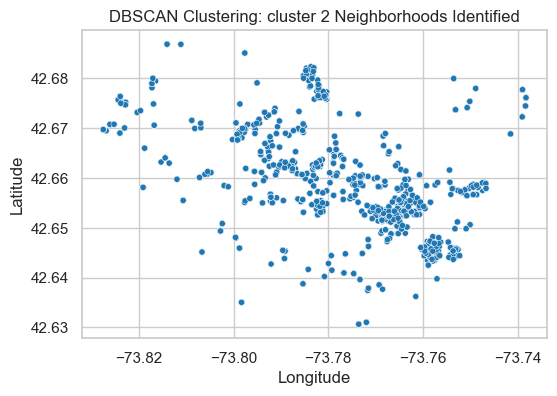

In [ ]:
# Identify the Top 3 largest clusters
top_clusters = df_processed['cluster'].value_counts().head(3).index
for c_id in top_clusters:
    cluster_listings = df_processed[df_processed['cluster'] == c_id]
    # Visualization (Sanity Check)
    plt.figure(figsize=(6, 4))
    sns.scatterplot(
        data=cluster_listings, 
        x='longitude', 
        y='latitude', 
        hue='cluster', 
        palette='tab20', # A palette with many distinct colors
        s=20, 
        legend=False # Turn off legend if there are too many clusters
    )  
    plt.title(f'DBSCAN Clustering: cluster {c_id} Neighborhoods Identified')
    plt.xlabel('Longitude')
    plt.ylabel('Latitude')
    plt.show()

---

## 5. Association Rules Mining and Unique Frequent Pattern Mining
### 5.1 Association Rules Mining
First, we will try to find all association rules that match the pattern: (amentias) ---> (High_Rated). In other words, we will mine each cluster separately and we will look for patterns where if specific amenities exist then Rating is High.

**Algorithm:** We will use **FP-Growth (Frequent Pattern Growth)**.



In [ ]:
def mine_cluster_patterns_optimized(cluster_id, df_full, min_sup=0.5, max_len=5):
    
    # Filter Data for this specific cluster
    cluster_data = df_full[df_full['cluster'] == cluster_id].copy()
    
    # Prepare the 'Basket' (Drop non-binary columns)
    # We remove lat/lon and cluster ID because they are not items in the basket
    cols_to_exclude = ['latitude', 'longitude', 'cluster', 'review_scores_rating', 'amenities', 'amenities_list', 'price']
    
    # Only drop columns that actually exist in the dataframe
    drop_cols = [c for c in cols_to_exclude if c in cluster_data.columns]
    basket = cluster_data.drop(columns=drop_cols)
    
    # FP-Growth is significantly faster and lighter with boolean data
    basket = basket.astype(bool)

    try:
        # Run FP-Growth
        frequent_itemsets = fpgrowth(basket, min_support=min_sup, use_colnames=True, max_len=max_len)
        
        if frequent_itemsets.empty:
            return pd.DataFrame()

        # Generate Rules
        rules = association_rules(frequent_itemsets, metric="lift", min_threshold=1)
        
        # Filter for Target: We only want rules that imply 'High_Rating'
        # consequent must be exactly {'High_Rating'}
        target_rules = rules[rules['consequents'] == frozenset({'High_Rating'})]
        
        # Clean up memory immediately
        del basket, frequent_itemsets, rules
        gc.collect()
        
        return target_rules.sort_values(by='lift', ascending=False)

    except MemoryError:
        print(f"  -> Memory Error in Cluster {cluster_id}. Try increasing min_support.")
        return pd.DataFrame()

# EXECUTION
cluster_rules_dict = {} # Store rules per cluster

print(f"Mining Association Rules for Top 3 Clusters...\n")
rules_df_dict = {}
for c_id in top_clusters:
    print(f"--- Mining Patterns in CLUSTER {c_id} ---")
    
    # Run the mining function
    rules_df = mine_cluster_patterns_optimized(c_id, df_processed, min_sup=0.5, max_len=3)

    if not rules_df.empty:
        rules_df['cluster_id'] = c_id
        cluster_rules_dict[c_id] = rules_df

Mining Association Rules for Top 3 Clusters...

--- Mining Patterns in CLUSTER 1 ---
--- Mining Patterns in CLUSTER 0 ---
--- Mining Patterns in CLUSTER 2 ---


Top 20 rules for cluster 1 with highest  lift score

In [45]:
cluster_rules_dict[1].filter(["antecedents","consequents", "support", "confidence", "lift"]).sort_values(by="lift",ascending=False).head(20)

,antecedents,consequents,support,confidence,lift
5649,"(Freezer, Coffee Maker)",(High_Rating),0.505460,0.928928,1.027657
5643,"(Freezer, Hot Water)",(High_Rating),0.509594,0.927514,1.026092
5631,"(Freezer, Dishes And Silverware)",(High_Rating),0.514436,0.926770,1.025269
5624,"(Freezer, Microwave)",(High_Rating),0.517006,0.925877,1.024281
5655,"(Freezer, Cooking Basics)",(High_Rating),0.503072,0.925716,1.024103
5619,"(Freezer, Refrigerator)",(High_Rating),0.521601,0.925237,1.023573
5440,(Freezer),(High_Rating),0.529754,0.924439,1.022691
5637,"(Freezer, Stove)",(High_Rating),0.512839,0.923673,1.021843
2708,"(Self Check-In, Hot Water)",(High_Rating),0.589294,0.919556,1.017289
334,"(Hangers, Hot Water)",(High_Rating),0.681693,0.917879,1.015434


Top 20 rules for cluster 0 with highest lift score

In [46]:
cluster_rules_dict[0].filter(["antecedents","consequents", "support", "confidence", "lift"]).sort_values(by="lift",ascending=False).head(20)

,antecedents,consequents,support,confidence,lift
5779,"(Freezer, Dishwasher)",(High_Rating),0.512555,0.949669,1.037157
11035,"(Carbon Monoxide Alarm, Extra Pillows And Blan...",(High_Rating),0.524082,0.944444,1.031451
11661,"(Cleaning Products, Carbon Monoxide Alarm)",(High_Rating),0.500491,0.943565,1.030490
11571,"(Cleaning Products, Coffee Maker)",(High_Rating),0.530962,0.942726,1.029574
3278,"(Hair Dryer, Dishwasher)",(High_Rating),0.575730,0.942510,1.029339
11174,"(Hair Dryer, Extra Pillows And Blankets)",(High_Rating),0.509963,0.942060,1.028847
11553,"(Cleaning Products, Hot Water)",(High_Rating),0.536592,0.941961,1.028738
11108,"(Iron, Extra Pillows And Blankets)",(High_Rating),0.513806,0.941542,1.028282
10958,"(Extra Pillows And Blankets, Hot Water)",(High_Rating),0.540256,0.941451,1.028182
11565,"(Cleaning Products, Refrigerator)",(High_Rating),0.532303,0.941074,1.027770


Top 20 rules for cluster 2 with highest lift score

In [47]:
cluster_rules_dict[2].filter(["antecedents","consequents", "support", "confidence", "lift"]).sort_values(by="lift",ascending=False).head(20)

,antecedents,consequents,support,confidence,lift
1910,"(Hair Dryer, Essentials)",(High_Rating),0.527704,0.949913,1.063378
2982,(Free Street Parking),(High_Rating),0.507622,0.943345,1.056026
2132,"(Essentials, Iron)",(High_Rating),0.545125,0.943072,1.055720
1766,"(Essentials, Hangers)",(High_Rating),0.573191,0.942698,1.055301
2232,"(Microwave, Essentials)",(High_Rating),0.542221,0.941992,1.054511
2011,"(Refrigerator, Essentials)",(High_Rating),0.568110,0.941082,1.053492
1494,"(Microwave, Hair Dryer)",(High_Rating),0.561578,0.939676,1.051918
2327,"(Shampoo, Hair Dryer)",(High_Rating),0.512219,0.939219,1.051407
2048,"(Essentials, Coffee Maker)",(High_Rating),0.562061,0.938586,1.050698
1261,"(Refrigerator, Hair Dryer)",(High_Rating),0.587951,0.937500,1.049482


### 5.1.1 Visualization of Findings
Visualizing the rules helps us quickly identify the "Hidden Gems" (High Lift, High Confidence) vs the "Standard Features" (High Support, Low Lift).

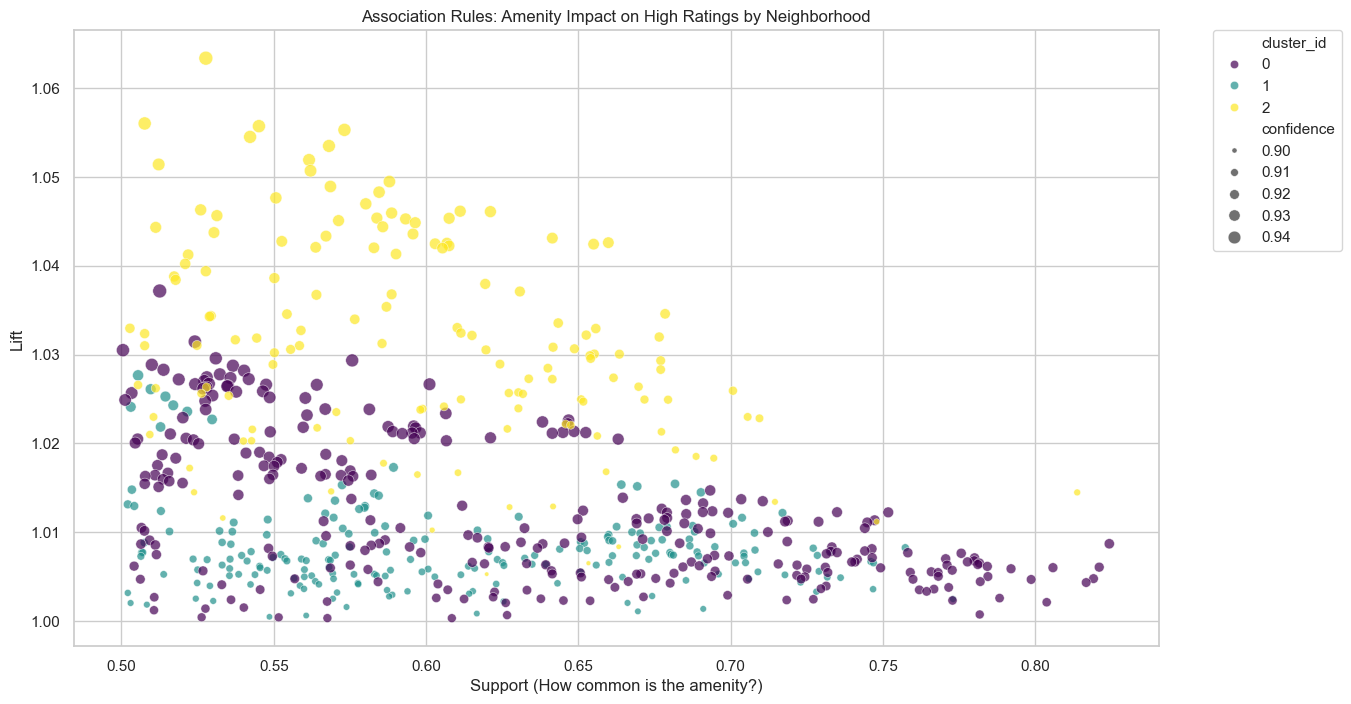

In [48]:
df_all_rules = pd.DataFrame()
for rules_df in cluster_rules_dict.values():
    df_all_rules  = pd.concat([df_all_rules, rules_df])
    
plt.figure(figsize=(14, 8))
# Convert 'antecedents' from frozenset to string for labeling
rules_df['rule_name'] = rules_df['antecedents'].apply(lambda x: list(x)[0] if len(x)==1 else str(tuple(x)))
# Scatter Plot: Support vs Lift
# Color = Cluster ID (to see differences between neighborhoods)
# Size = Confidence (Bigger bubble = more certain rule)
sns.scatterplot(
    data=df_all_rules,
    x="support",
    y="lift",
    hue="cluster_id",
    size="confidence",
    sizes=(10, 100),
    palette="viridis",
    alpha=0.7
)

plt.title("Association Rules: Amenity Impact on High Ratings by Neighborhood")
plt.xlabel("Support (How common is the amenity?)")
plt.ylabel("Lift")
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

### 5.2 Find Unique amenities of High-Rated Groups (Contrast Set Mining)

**Contrast Set Mining Strategy:**
Finding *general* rules often leads to obvious results (e.g., "Wifi implies High Rating" is true everywhere). To find actionable insights, we employ **Contrast Set Mining**:
1.  Mine frequent patterns for **High-Rated** listings in a cluster.
2.  Mine frequent patterns for **Low-Rated** listings in the same cluster.
3.  **Subtract** the two sets.
The remaining patterns are the **Unique Success Factors**—amenities that distinguish the winners from the losers in that specific neighborhood.

In [ ]:
def mine_contrast_patterns(cluster_id, df_full, min_sup_high=0.1, min_sup_low=0.1):
    """
    Finds itemsets that are frequent in High Rated listings 
    but RARE or ABSENT in Low Rated listings.
    """
    print(f"\n\n--- Mining Unique high-rated patterns in Cluster {cluster_id} ---")
    
    # Split Data into High and Low/Medium groups
    cluster_data = df_full[df_full['cluster'] == cluster_id]
    
    df_high = cluster_data[cluster_data['High_Rating'] == 1]
    df_low  = cluster_data[cluster_data['High_Rating'] == 0]
    
    # Check if we have enough data
    if len(df_high) < 10 or len(df_low) < 10:
        print("  -> Not enough data in split groups to compare.")
        return pd.DataFrame()

    # Prepare Baskets (Drop metadata)
    drop_cols = ['latitude', 'longitude', 'cluster', 'review_scores_rating', 'amenities', 
                 'amenities_list', 'High_Rating', 'price']
    
    basket_high = df_high.drop(columns=[c for c in drop_cols if c in df_high.columns]).astype(bool)
    basket_low  = df_low.drop(columns=[c for c in drop_cols if c in df_low.columns]).astype(bool)

    # Mine Frequent Itemsets for BOTH groups
    frequent_low  = fpgrowth(basket_low,  min_support=min_sup_low,  use_colnames=True, max_len=3)
    frequent_high = fpgrowth(basket_high, min_support=min_sup_high, use_colnames=True, max_len=3)
    
    if frequent_high.empty:
        print("  -> No frequent patterns in High group.")
        return pd.DataFrame()
        
    # Perform Set Difference (The "Contrast" Step)
    # We want items in High that are NOT in Low
    
    # Convert itemsets to frozensets for comparison
    high_sets = set(frequent_high['itemsets'])
    low_sets  = set(frequent_low['itemsets']) if not frequent_low.empty else set()
    print('high_sets len', len(high_sets))
    print('low_sets len', len(low_sets))
    # The Subtraction
    unique_sets = high_sets - low_sets
    print('unique_sets len', len(unique_sets))

    # Filter the results dataframe to keep only unique sets
    # We merge to keep the 'support' column from the High group
    df_unique = frequent_high[frequent_high['itemsets'].isin(unique_sets)].copy()
    
    # Sort by Support (How common is this success factor?)
    df_unique = df_unique.sort_values(by='support', ascending=False)
    
    return df_unique

# EXECUTION
top_clusters = df_processed['cluster'].value_counts().head(3).index.tolist()

unique_patterns_dict ={}
for c_id in top_clusters:
    print(f"Mining for cluster({c_id}) ...")
    unique_patterns = mine_contrast_patterns(c_id, df_processed, min_sup_high=0.5, min_sup_low=0.35)
    unique_patterns_dict[c_id] = unique_patterns

    if not unique_patterns.empty:
        print(f"\nUnique Success Factors for Cluster {c_id}:")        
        # Interpretation
        top_item = list(unique_patterns.iloc[0]['itemsets'])
        print(f"  -> Insight: Listings in this area with {top_item} are consistently highly rated, whereas low-rated listings almost never have this.")
    else:
        print("\n  -> No unique differentiators found (High and Low listings look the same here).")

Mining for cluster(1) ...


--- Mining Unique high-rated patterns in Cluster 1 ---
high_sets len 1380
low_sets len 2321
unique_sets len 15

Unique Success Factors for Cluster 1:
  -> Insight: Listings in this area with ['Refrigerator', 'Extra Pillows And Blankets', 'Hot Water'] are consistently highly rated, whereas low-rated listings almost never have this.
Mining for cluster(0) ...


--- Mining Unique high-rated patterns in Cluster 0 ---
high_sets len 2170
low_sets len 3002
unique_sets len 117

Unique Success Factors for Cluster 0:
  -> Insight: Listings in this area with ['Hair Dryer', 'Iron', 'Dishwasher'] are consistently highly rated, whereas low-rated listings almost never have this.
Mining for cluster(2) ...


--- Mining Unique high-rated patterns in Cluster 2 ---
high_sets len 938
low_sets len 695
unique_sets len 382

Unique Success Factors for Cluster 2:
  -> Insight: Listings in this area with ['Essentials', 'Hangers'] are consistently highly rated, whereas low-rated listing

Visualizing the "Value Gap"
This visualization shows which amenities define the gap between "Good" and "Bad" listings.

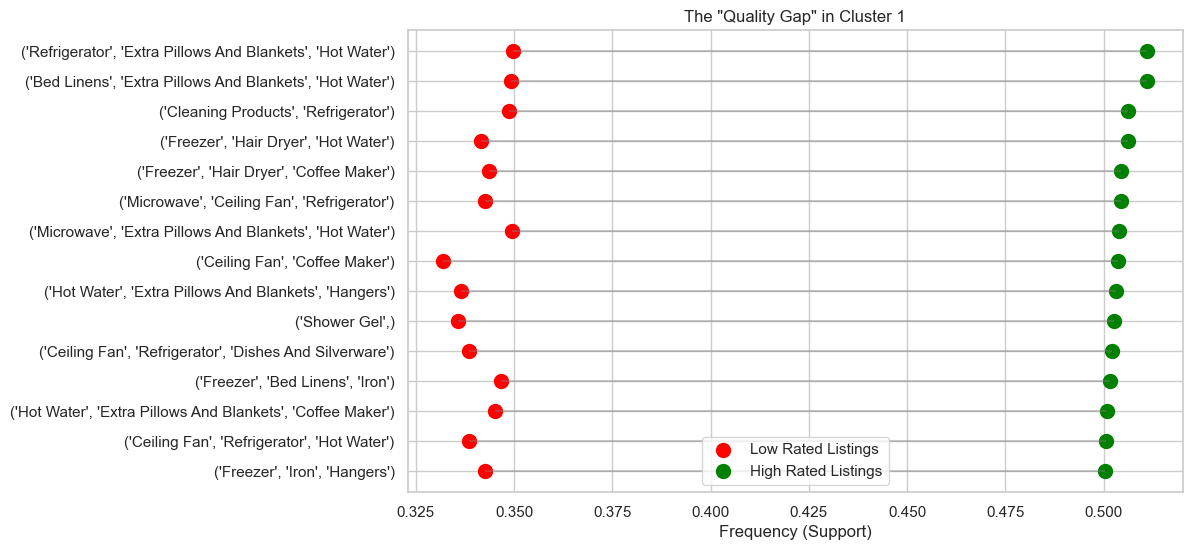

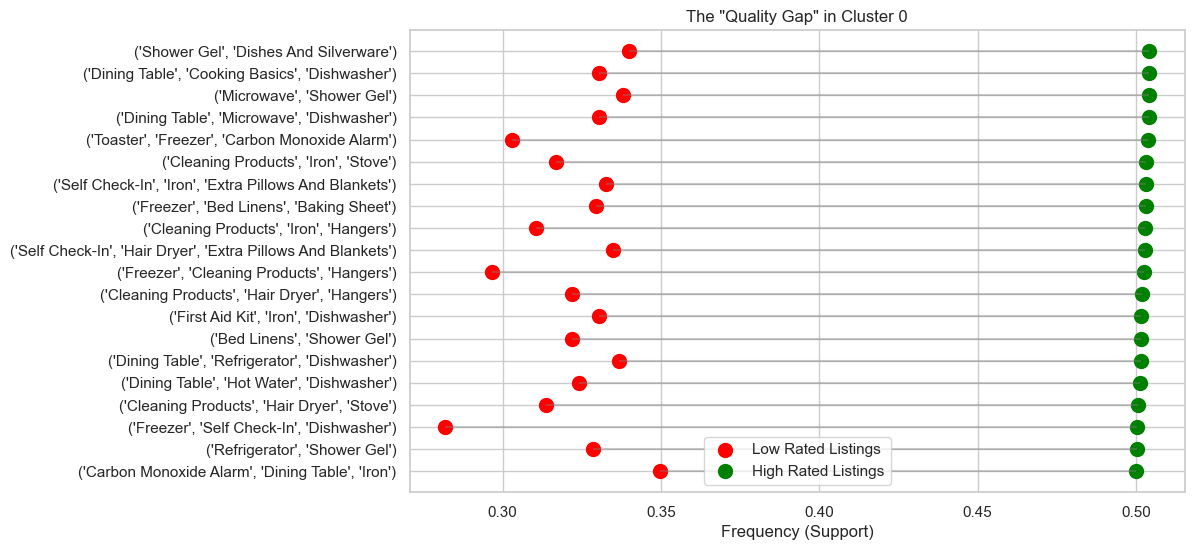

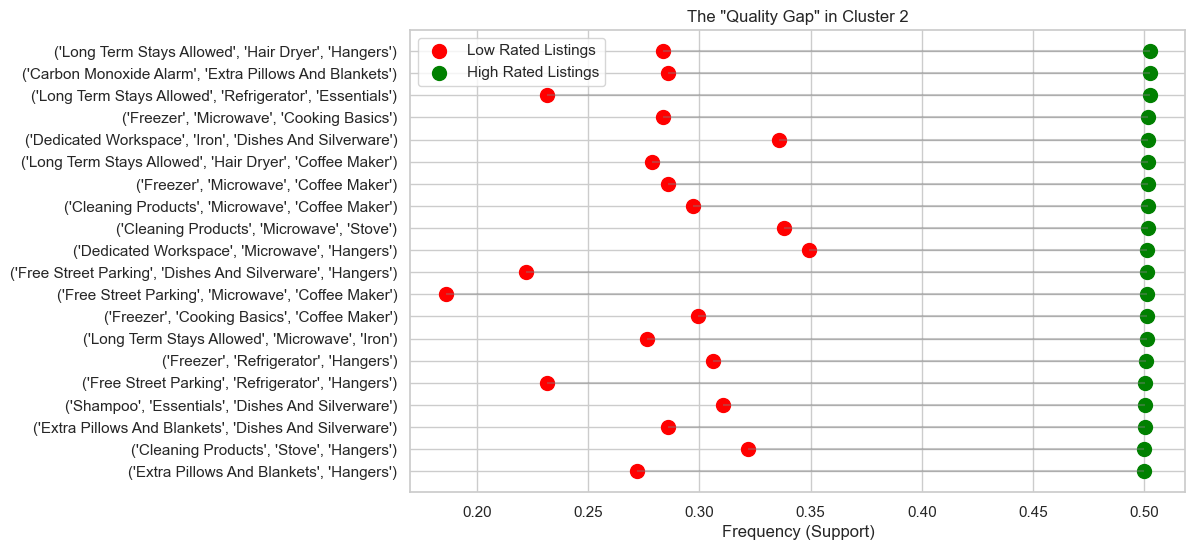

In [50]:
def plot_contrast_gap(cluster_id, df_full, pattern_df):
    """
    Visualizes the Support Gap: How frequent is it in High vs Low?
    """
    # Recalculate support in LOW group for the unique patterns
    cluster_data = df_full[df_full['cluster'] == cluster_id]
    df_low = cluster_data[cluster_data['High_Rating'] == 0]
    
    low_supports = []
    patterns = []
    high_supports = []
    
    for _, row in pattern_df.sort_values(by="support", ascending=True).head(20).iterrows(): # Top 10 patterns
        cols = list(row['itemsets'])
        # Calculate support in Low group manually
        sup_low = (df_low[cols] == 1).all(axis=1).mean()
        
        patterns.append(str(tuple(cols)))
        low_supports.append(sup_low)
        high_supports.append(row['support'])

    # Plotting
    plt.figure(figsize=(10, 6))
    y_range = range(len(patterns))
    
    # Draw lines connecting the dots (The Gap)
    plt.hlines(y=y_range, xmin=low_supports, xmax=high_supports, color='grey', alpha=0.4)
    
    # Plot Dots
    plt.scatter(low_supports, y_range, color='red', alpha=1, label='Low Rated Listings', s=100)
    plt.scatter(high_supports, y_range, color='green', alpha=1, label='High Rated Listings', s=100)
    
    plt.yticks(y_range, patterns)
    plt.title(f'The "Quality Gap" in Cluster {cluster_id}')
    plt.xlabel('Frequency (Support)')
    plt.legend()
    plt.show()

# Run Visualization
i = 0
for unique_patterns in unique_patterns_dict.values():
    if not unique_patterns.empty:
        plot_contrast_gap(top_clusters[i], df_processed, unique_patterns)
    i+=1

#### Financial Impact Analysis

Finally, we calculate the "Average Price" of each unique pattern in a cluster, this may help the host or property owner answers: **"How much more money does a listing make if it has this unique pattern?"**

In [ ]:
def enrich_patterns_with_price(cluster_id, df_full, unique_patterns_df):
    """
    Calculates the average price difference for listings holding the unique patterns.
    """
    # Get data for this cluster
    cluster_data = df_full[df_full['cluster'] == cluster_id].copy()

    # Clean price column (remove $ and commas if present)
    # Assuming price is string "$1,200.00" -> float 1200.00
    baseline_price = 0
    if cluster_data['price'].dtype == 'O':
        cluster_data['price'] = cluster_data['price'].replace('[\\$,]', '', regex=True).astype(float)
        baseline_price = cluster_data['price'].mean()

    enriched_results = []

    for index, row in unique_patterns_df.iterrows():
        pattern = row['itemsets']
        
        # Find all listings in this cluster that HAVE this pattern
        # We check if the pattern is a subset of the listing's amenities
        # Create a boolean mask for listings containing ALL items in the pattern
        cols = list(pattern)
        mask = (cluster_data[cols] == 1).all(axis=1)
        
        matched_listings = cluster_data[mask]
        
        if len(matched_listings) > 0:
            avg_price_pattern = matched_listings['price'].mean()
            
            enriched_results.append({
                'Pattern': list(pattern),
                'Support_High': row['support'],
                'Avg_Price': round(avg_price_pattern, 2),
                'Listing_Count': len(matched_listings),
                'base_line_price': round(baseline_price, 2)
            })
    return pd.DataFrame(enriched_results).sort_values(by='Avg_Price', ascending=False)

impact_dict = {}
for c_id in top_clusters:
    if(not unique_patterns_dict[c_id].empty):
        impact_dict[c_id] = enrich_patterns_with_price(c_id, df_processed, unique_patterns_dict[c_id]) # Use raw 'df' for price column

In [52]:
#for c_id in top_clusters:
#    if(not unique_patterns_dict[c_id].empty):
#        print(f"\n\n\n--- Financial Impact of Unique Amenities in Cluster {c_id} ---\n")
#        print(impact_dict[c_id].head(15).to_string(index=False))

In [53]:
print(f"\n--- Financial Impact of Unique Amenities in Cluster {0} ---\n")
print(impact_dict[0].head(15).to_string(index=False))


--- Financial Impact of Unique Amenities in Cluster 0 ---

                                                           Pattern  Support_High  Avg_Price  Listing_Count  base_line_price
                 [Self Check-In, Iron, Extra Pillows And Blankets]      0.503269     249.95           5471            183.6
[Carbon Monoxide Alarm, Self Check-In, Extra Pillows And Blankets]      0.509515     248.64           5524            183.6
                    [Essentials, Iron, Extra Pillows And Blankets]      0.509222     248.60           5543            183.6
   [Carbon Monoxide Alarm, Essentials, Extra Pillows And Blankets]      0.513028     248.57           5565            183.6
           [Self Check-In, Hair Dryer, Extra Pillows And Blankets]      0.502781     248.39           5468            183.6
              [Hair Dryer, Essentials, Extra Pillows And Blankets]      0.505904     247.83           5505            183.6
         [Carbon Monoxide Alarm, Iron, Extra Pillows And Blankets]      

In [54]:
print(f"\n--- Financial Impact of Unique Amenities in Cluster {1} ---\n")
print(impact_dict[1].head(15).to_string(index=False))


--- Financial Impact of Unique Amenities in Cluster 1 ---

                                              Pattern  Support_High  Avg_Price  Listing_Count  base_line_price
[Hot Water, Extra Pillows And Blankets, Coffee Maker]      0.500802     223.03          29498           333.49
     [Hot Water, Extra Pillows And Blankets, Hangers]      0.503207     222.19          29580           333.49
[Refrigerator, Extra Pillows And Blankets, Hot Water]      0.511115     220.05          30091           333.49
   [Microwave, Extra Pillows And Blankets, Hot Water]      0.503754     219.96          29685           333.49
  [Bed Linens, Extra Pillows And Blankets, Hot Water]      0.511097     218.16          30087           333.49
                                         [Shower Gel]      0.502715     201.91          29549           333.49
                  [Freezer, Hair Dryer, Coffee Maker]      0.504318     195.75          29682           333.49
                     [Freezer, Hair Dryer, Hot Water

In [55]:
print(f"\n--- Financial Impact of Unique Amenities in Cluster {2} ---\n")
print(impact_dict[2].head(15).to_string(index=False))


--- Financial Impact of Unique Amenities in Cluster 2 ---

                                               Pattern  Support_High  Avg_Price  Listing_Count  base_line_price
              [Hair Dryer, Fire Extinguisher, Hangers]      0.539274     137.51           2133           117.23
                 [Hair Dryer, Iron, Fire Extinguisher]      0.527898     136.47           2096           117.23
       [Hair Dryer, Cooking Basics, Fire Extinguisher]      0.530065     136.18           2091           117.23
              [Essentials, Fire Extinguisher, Hangers]      0.513001     136.08           1998           117.23
                [Hair Dryer, Fire Extinguisher, Stove]      0.514626     135.99           2040           117.23
        [Self Check-In, Hair Dryer, Fire Extinguisher]      0.530607     135.97           2095           117.23
                      [Iron, Fire Extinguisher, Stove]      0.513814     135.74           2050           117.23
         [Essentials, Fire Extinguisher, Cof

## 6. Project Summary and Findings

### 6.1 Data Processing Results
* **Dataset Volume:** We successfully processed a dataset of **76,255 listings**.
* **Feature Engineering:** We parsed raw text amenities into **151 distinct binary features**, effectively cleaning duplicates (e.g., consolidating "WiFi" and "Internet").
* **Target Definition:** We defined "High Rating" as listings with a score $\ge$ 4.5, which allowed us to convert the problem into a binary classification suited for pattern mining.

### 6.2 Clustering Insights
Using DBSCAN with the Haversine metric, we achieved a high-quality segmentation of the market.
* **Optimal Parameters:** The grid search identified the best hyperparameters as **Epsilon (eps) = 3 km** and **Min Samples = 15**.
* **Cluster Quality:** This configuration yielded a strong **Silhouette Score of 0.704**, indicating that the clusters are well-separated and dense.
* **Geographic Segmentation:** The algorithm identified **3 distinct functional neighborhoods**. This suggests the dataset covers 3 major dense urban across the three states, ignoring other clusters listings (noise).

### 6.3 Amenity Analysis Findings
* we mined each cluster separately and we searched for patterns where if specific amenities exist then Room Rating is High. We used FP-Growth (Frequent Pattern Growth) to mine frequent itemsets of amenities. Below is a list of some of the interesting rules that we found after this step:
- Cluster 1: (Self Check-In, Coffee Maker) → (High_Rating) [lift=1.014]
- Cluster 0: (Cleaning Products, Carbon Monoxide Alarm) → (High_Rating) [lift=1.03]
- Cluster 2: (Free Street Parking) → (High_Rating) [lift=1.03]
* Also we used (Contrast Set Mining) to find Unique Success Factors—amenities that distinguish the high-rated from the low-rated in that specific neighborhood. The results of the step is illustrated using Quality(Support) Gap figures as mentioned above.